## Overview
This notebook demonstrates how to build an AI-based Image Captioning System using a state-of-the-art pre-trained model. The system generates meaningful natural language descriptions for images by combining Vision Transformer (ViT) for image feature extraction and GPT-2 for caption generation. The implementation utilizes the nlpconnect/vit-gpt2-image-captioning model available on Hugging Face.

Table of Contents
- Setup and Module Imports
- Image Captioning with Pre-trained Model
- Evaluate Model Performance
- Test with Real Images
- Real-time Captioning with Webcam

### 1. Setup and Module Imports

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade transformers torch nltk gradio matplotlib seaborn tqdm pillow opencv-python tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 

In [3]:
!git clone https://github.com/salaniz/pycocoevalcap.git

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (424/424), done.


In [4]:
# Navigate to the directory
%cd pycocoevalcap

# Install the library in editable mode
!pip install -e .

/content/pycocoevalcap
Obtaining file:///content/pycocoevalcap
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pycocoevalcap


In [5]:
%cd ..


/content


In [6]:
!pip install --upgrade tensorflow

#### Importing libraries

In [7]:
!pip install keras

In [1]:

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow import keras

from keras import applications
from keras.applications import InceptionV3


from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Hugging Face Transformers for image captioning
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

import gradio as gr
import nltk
from nltk.translate.bleu_score import corpus_bleu


from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

d:\Python\python jobs\imageCaptioning\Venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### Load the pre-trained ViT-GPT2 model and processor from Hugging Face

model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# *Modified* Ensure image_id matches the zero-padded image filenames
def get_image_path(image_id):
    """
    Constructs the image file path based on the image_id with zero padding.
    
    Args:
        image_id (int): Image ID from annotations.
        
    Returns:
        str: Path to the image file.
    """
    filename = f"{image_id:012}.jpg"  # Zero-pad to 12 digits
    return os.path.join(BASE_DIR, 'images', filename)

# *Modified* Load image_ids from test.data and train.data
def load_image_ids(data_file):
    """
    Loads image_ids from a .data file.
    
    Args:
        data_file (str): Path to the .data file.
        
    Returns:
        set: A set of image_ids.
    """
    with open(os.path.join(BASE_DIR, 'annotations', data_file), 'r') as f:
        data = f.read().splitlines()
    image_ids = set()
    for line in data:
        # Assuming each line contains image_id and other info separated by tabs or commas
        parts = line.split('\t')  # Adjust the delimiter based on your .data file
        image_id = int(parts[0])  # Adjust the index based on your file structure
        image_ids.add(image_id)
    return image_ids

# *Modified* Load image_ids for evaluation
train_image_ids = load_image_ids('train.data')
test_image_ids = load_image_ids('test.data')

# *Modified* Filter mapping to include only train and test image_ids
evaluation_image_ids = train_image_ids.union(test_image_ids)

mapping = {}
for annot in annotations['annotations']:
    image_id = annot['image_id']
    if image_id in evaluation_image_ids:  # *Modified*
        caption = annot['caption']
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)

print(f"Number of images with captions: {len(mapping)}")

In [4]:
BASE_DIR = 'ML/images'
WORKING_DIR = 'ML'


# BASE_DIR = '/content/drive/MyDrive/ML/images'
# WORKING_DIR = '/content/drive/MyDrive/ML'

## 2. Image Captioning

### Load the pre-trained ViT-GPT2 model and processor from Hugging Face

In [10]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

: 

In [ ]:
# *Modified* Load the pre-trained model with proper device configuration
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

model.to(device)  # Move model to GPU if available

In [13]:

max_length = 16
num_beams = 4

#### Load the Pickled Annotations

In [14]:

annotations_pickle_path = os.path.join(BASE_DIR, 'annotations', 'potentials_dev.pkl')

# Load the pickled annotations with the correct encoding
with open(annotations_pickle_path, 'rb') as f:
    annotations = pickle.load(f, encoding='latin1')

#### Setting Generation Parameters

In [15]:
max_length = 16
num_beams = 4

#### Caption Generation Function

In [16]:
def generate_caption(image_input):
    """
    Generates a caption for the given image.

    Args:
        image_input (str or PIL.Image): Path to the image or a PIL Image object.

    Returns:
        str: Generated caption.
    """
    if isinstance(image_input, str):
        image = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        image = image_input
    else:
        raise ValueError("Invalid image_input type. Must be a file path or PIL Image.")

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values

    output_ids = model.generate(pixel_values, max_length=max_length, num_beams=num_beams)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    print("Generated Caption:", caption)
    return caption


In [17]:
def generate_caption_return(image_input):
    """
    Generates a caption for the given image.

    Args:
        image_input (str or PIL.Image): Path to the image or a PIL Image object.

    Returns:
        str: Generated caption.
    """
    if isinstance(image_input, str):
        image = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        image = image_input
    else:
        raise ValueError("Invalid image_input type. Must be a file path or PIL Image.")

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values

    output_ids = model.generate(pixel_values, max_length=max_length, num_beams=num_beams)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    print("Generated Caption:", caption)
    return caption

##### Generate caption for a single image

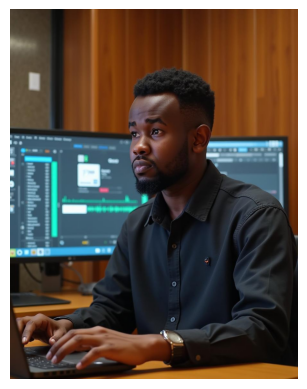

Generated Caption: a man sitting at a desk in front of a laptop computer 


'a man sitting at a desk in front of a laptop computer '

In [46]:
image = os.path.join(BASE_DIR, 'images', '18924189-3.jpg')
# image = os.path.join(BASE_DIR, 'images', "Arrow 3.png")
# image1 = os.path.join(BASE_DIR, 'images', "Arrows.png")
#image2 = os.path.join(BASE_DIR, 'images', "IMG_20190718_125955-1~3.jpg")
# image3 = os.path.join(BASE_DIR, 'images', "maxresdefault.jpg")
#image4 = os.path.join(BASE_DIR, 'images', "Officials.jpg")
# image5 = os.path.join(BASE_DIR, 'images', "WhatsApp Image 2024-04-26 at 09.51.51.jpeg")
# image6 = os.path.join(BASE_DIR, 'images', "WhatsApp Image 2024-05-15 at 14.12.41.jpeg")



generate_caption(image)

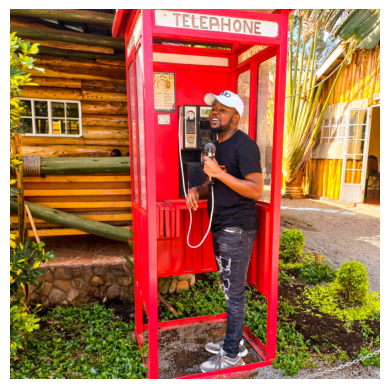

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Generated Caption: a man talking on a cell phone in front of a fire hydrant 


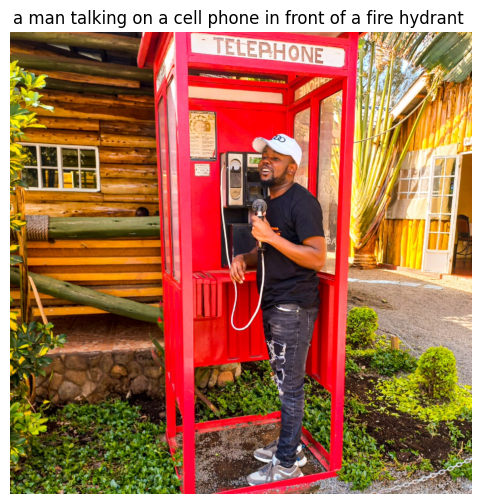

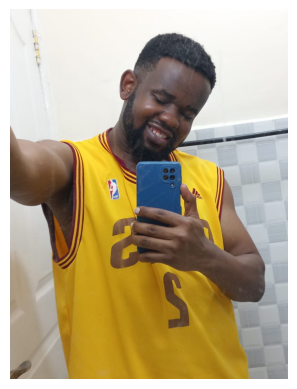

Generated Caption: a man holding a cell phone in his hand 


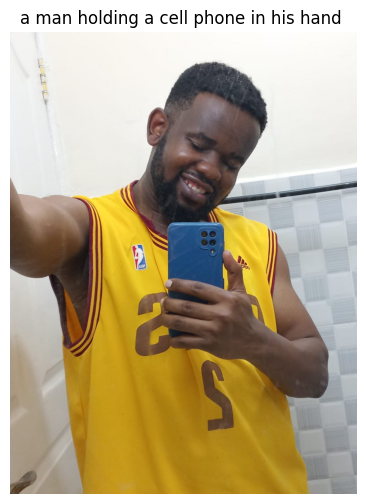

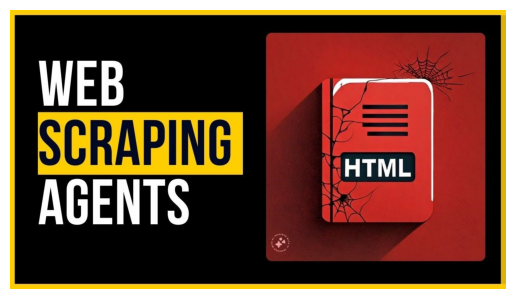

Generated Caption: a red and white sign on a red and white sign 


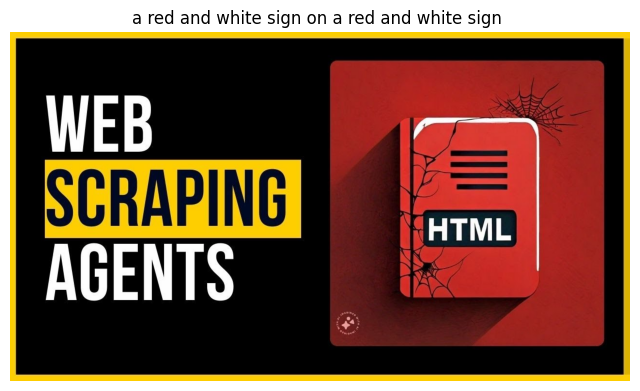

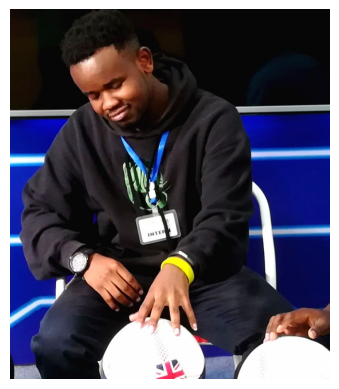

Generated Caption: a man sitting at a table with a plate of food 


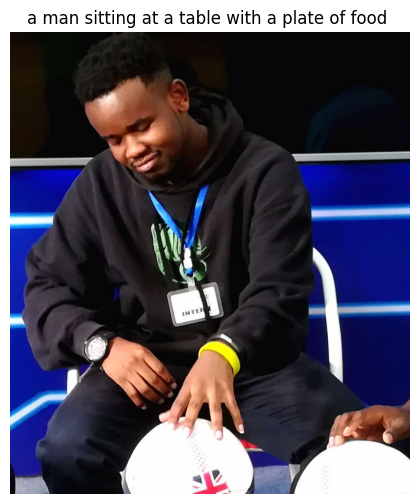

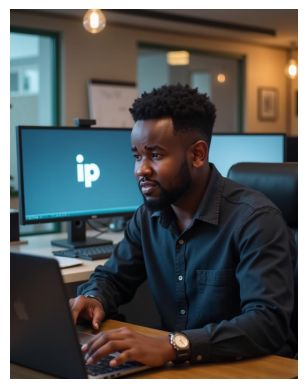

Generated Caption: a man sitting in front of a laptop computer 


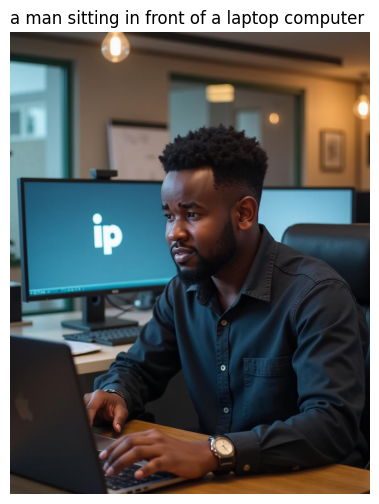

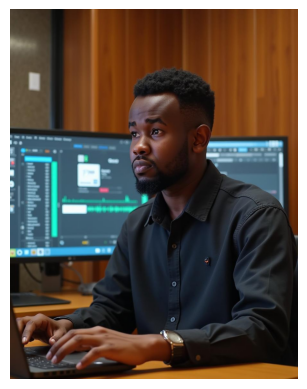

Generated Caption: a man sitting at a desk in front of a laptop computer 


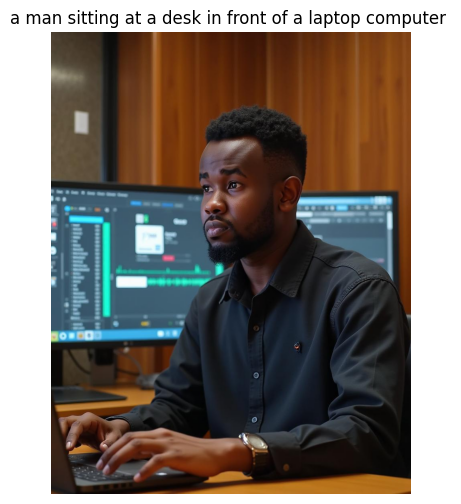

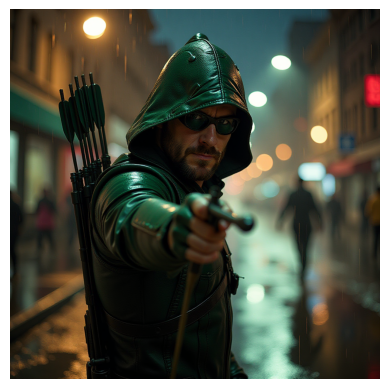

Generated Caption: a man wearing a mask and holding a knife 


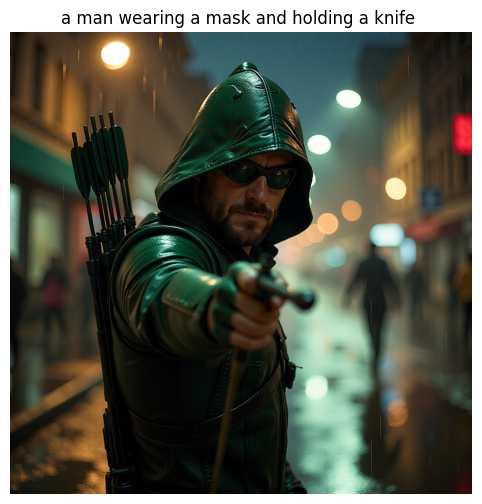

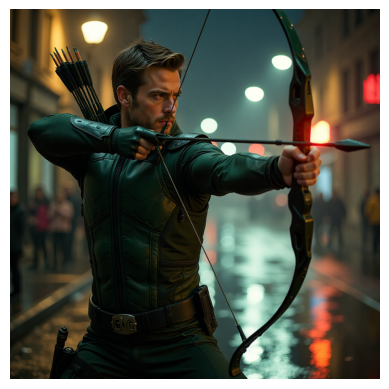

Generated Caption: a man in a black and white photo holding a knife 


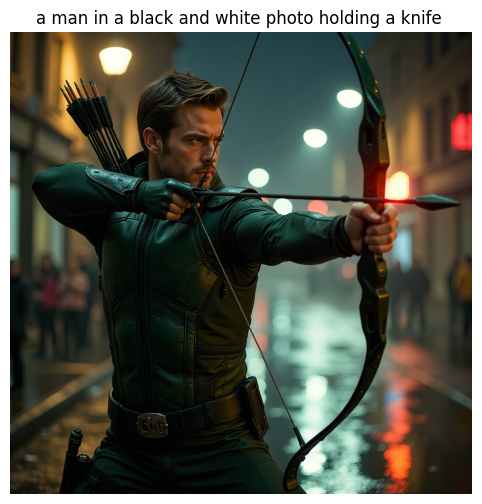

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the images directory
images_dir = os.path.join(BASE_DIR, 'images')

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Iterate through each image file
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)

    # Generate caption
    caption = generate_caption(image_path)

    # Display the image with its caption
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()

## 3. Evaluate Model Performance

Utilizing evaluation metrics to assess caption quality against ground truth.

### Loading Ground Truth Captions

In [19]:
# Load captions - MS COCO format; adjust as necessary
import json

annotations_file = os.path.join(BASE_DIR, 'annotations', 'captions_val2017.json')

with open(annotations_file, 'r') as f:
    annotations = json.load(f)

mapping = {}
for annot in annotations['annotations']:
    image_id = annot['image_id']
    caption = annot['caption']
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

print(f"Number of images with captions: {len(mapping)}")



Number of images with captions: 5000


#### Generating Captions for Evaluation

In [20]:
generated_captions = {}
num_evaluate = 100

for idx, (image_id, captions) in tqdm(enumerate(mapping.items()), total=len(mapping)):
    if idx >= num_evaluate:
        break
    image_path = os.path.join(BASE_DIR, 'Images', f"{image_id}.jpg")
    if os.path.exists(image_path):
        try:
            caption = generate_caption_return(image_path)  # Use the updated function
            if caption.strip():  # Check if caption is not empty or just whitespace
                generated_captions[image_id] = caption
                print(f"Generated caption for image_id {image_id}: {caption}")  # Debug statement
            else:
                print(f"Warning: Empty caption generated for image_id {image_id}.")  # Debug statement
        except Exception as e:
            print(f"Error generating caption for image_id {image_id}: {e}")  # Handle exceptions
    else:
        print(f"Warning: Image file {image_path} does not exist.")  # Debug statement

# Summary of generated captions
print(f"Total generated captions: {len(generated_captions)}")

# Debugging: Print the number of items in mapping and generated_captions
print(f"Total images in mapping: {len(mapping)}")
print(f"Total generated captions: {len(generated_captions)}")

   # Debugging: Print some sample keys to verify overlap
sample_mapping_keys = set(list(mapping.keys())[:5])
sample_generated_keys = set(list(generated_captions.keys())[:5])
print(f"Sample keys in mapping: {sample_mapping_keys}")
print(f"Sample keys in generated_captions: {sample_generated_keys}")

   # Debugging: Print a few generated captions
for image_id in list(generated_captions.keys())[:5]:
  print(f"Image ID: {image_id}, Caption: {generated_captions[image_id]}")






  0%|          | 0/5000 [00:00<?, ?it/s]

Total generated captions: 0
Total images in mapping: 5000
Total generated captions: 0
Sample keys in mapping: {517069, 182417, 179765, 331352, 190236}
Sample keys in generated_captions: set()


#### Updating the generate_caption function to return captions instead of printing.

## 4. Computing Evaluation Metrics

#### For evaluation

In [ ]:
# *Modified* Evaluation and Visualization Functions
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

def evaluate_and_visualize(image_path, actual_caption=None):
    """
    Evaluate model on single image and visualize results
    """
    # Load and process image
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    
    # Generate caption
    pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=num_beams,
        return_dict_in_generate=True,
        output_scores=True
    )
    
    # Decode caption
    predicted_caption = tokenizer.decode(output_ids.sequences[0], skip_special_tokens=True)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Image with caption
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Generated Caption:\n" + predicted_caption, fontsize=12)
    plt.axis('off')
    
    # Confidence scores
    if actual_caption:
        plt.subplot(1, 2, 2)
        bleu_score = sentence_bleu([actual_caption.split()], predicted_caption.split())
        plt.text(0.1, 0.5, f"BLEU Score: {bleu_score:.4f}\n\nActual Caption:\n{actual_caption}", 
                fontsize=12, wrap=True)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_caption

Compute BLEU, METEOR, and CIDEr scores

In [51]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.cider.cider import Cider

nltk.download('punkt')

references = []
hypotheses = []

for image_id, captions in mapping.items():
    if image_id in generated_captions:
        tokenized_captions = [nltk.tokenize.word_tokenize(c.lower()) for c in captions]
        references.append(tokenized_captions)

        # Tokenize the generated caption
        tokenized_caption = nltk.tokenize.word_tokenize(generated_captions[image_id].lower())
        if tokenized_caption:  # *Modified* Check if tokenized_caption is not empty
            hypotheses.append(tokenized_caption)
            print(f"Tokenized hypothesis for image_id {image_id}: {tokenized_caption}")  # *Modified* Debug statement
        else:
            print(f"Warning: Tokenized caption for image_id {image_id} is empty and will be skipped.")  # *Modified* Debug statement

# *Modified* Add debug statements to check references and hypotheses
print(f"Number of references: {len(references)}")  # *Modified* Debug statement
print(f"Number of hypotheses: {len(hypotheses)}")  # *Modified* Debug statement

# *Modified* Check if references and hypotheses are not empty before computing BLEU scores
if references and hypotheses:
    # Compute BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    bleu_scores = {'bleu1': bleu1, 'bleu2': bleu2, 'bleu3': bleu3, 'bleu4': bleu4}

    print(f'BLEU-1: {bleu1:.4f}')
    print(f'BLEU-2: {bleu2:.4f}')
    print(f'BLEU-3: {bleu3:.4f}')
    print(f'BLEU-4: {bleu4:.4f}')

    for k, v in bleu_scores.items():
        print(f"{k}: {v:.4f}")

    # Plot BLEU scores
    def plot_bleu_scores(bleu_scores):
        plt.figure(figsize=(8, 6))
        labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
        scores = [bleu_scores['bleu1'], bleu_scores['bleu2'], bleu_scores['bleu3'], bleu_scores['bleu4']]
        sns.barplot(x=labels, y=scores, palette='viridis')
        plt.ylim(0, 1)
        plt.title('BLEU Scores')
        plt.ylabel('Score')
        plt.show()

    plot_bleu_scores(bleu_scores)
else:
    print("No references or hypotheses available to compute BLEU scores.")  # *Modified* Inform when no data is available


Number of references: 0
Number of hypotheses: 0
No references or hypotheses available to compute BLEU scores.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

nltk.download('punkt')

# Initialize evaluators
meteor_evaluator = Meteor()
cider_evaluator = Cider()

# Prepare COCO format references and hypotheses
coco_format_references = {}
coco_format_hypotheses = {}

for image_id, captions in mapping.items():
    if image_id in generated_captions:
        # Prepare references in COCO format
        coco_format_references[image_id] = [{'caption': c} for c in captions]

        # Prepare hypotheses in COCO format
        generated_caption = generated_captions[image_id]
        if generated_caption.strip():  # Ensure caption is not empty
            coco_format_hypotheses[image_id] = [generated_caption]
            print(f"Generated hypothesis for image_id {image_id}: {generated_caption}")  # Debug statement
        else:
            print(f"Warning: Generated caption for image_id {image_id} is empty and will be skipped.")  # Debug statement

# Summary of generated captions
print(f"Total generated captions: {len(coco_format_hypotheses)}")
print(f"Total images in mapping: {len(mapping)}")
print(f"Total generated captions: {len(coco_format_hypotheses)}")

# Debugging: Print some sample keys to verify overlap
sample_mapping_keys = set(list(mapping.keys())[:5])
sample_generated_keys = set(list(coco_format_hypotheses.keys())[:5])
print(f"Sample keys in mapping: {sample_mapping_keys}")
print(f"Sample keys in generated_captions: {sample_generated_keys}")

# Debugging: Print a few generated captions
for image_id in list(coco_format_hypotheses.keys())[:5]:
    print(f"Image ID: {image_id}, Caption: {coco_format_hypotheses[image_id][0]}")

# Compute METEOR score
try:
    meteor_score, _ = meteor_evaluator.compute_score(coco_format_references, coco_format_hypotheses)
    print(f'METEOR: {meteor_score:.4f}')
except Exception as e:
    print(f"Error computing METEOR score: {e}")

# Compute CIDEr score
try:
    cider_score, _ = cider_evaluator.compute_score(coco_format_references, coco_format_hypotheses)
    print(f'CIDEr: {cider_score:.4f}')
except Exception as e:
    print(f"Error computing CIDEr score: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total generated captions: 0
Total images in mapping: 5000
Total generated captions: 0
Sample keys in mapping: {517069, 182417, 179765, 331352, 190236}
Sample keys in generated_captions: set()
Error computing METEOR score: could not convert string to float: b'Error: specify Meteor stats'
Error computing CIDEr score: max() arg is an empty sequence


In [ ]:
# *Modified* Batch Evaluation Function
def evaluate_batch(image_paths, actual_captions=None):
    """
    Evaluate model on a batch of images
    """
    results = []
    metrics = {'bleu': [], 'meteor': [], 'cider': []}
    
    for idx, img_path in enumerate(tqdm(image_paths)):
        pred_caption = evaluate_and_visualize(
            img_path, 
            actual_captions[idx] if actual_captions else None
        )
        results.append({
            'image': img_path,
            'predicted': pred_caption,
            'actual': actual_captions[idx] if actual_captions else None
        })
        
        if actual_captions:
            # Calculate metrics
            bleu = sentence_bleu([actual_captions[idx].split()], pred_caption.split())
            metrics['bleu'].append(bleu)
    
    # Plot overall metrics
    if actual_captions:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=pd.DataFrame(metrics))
        plt.title('Distribution of Evaluation Metrics')
        plt.show()
    
    return results, metrics

In [25]:
# Display sample predictions
def display_image_captions(image_path, actual_captions, generated_caption):
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Generated Caption: " + generated_caption, fontsize=14, color='blue')
    plt.suptitle("Actual Captions:\n" + "\n".join(actual_captions), fontsize=10, color='green')
    plt.show()

def display_sample_predictions(sample_size=5):
    sampled_keys = list(generated_captions.keys())[:sample_size]
    for image_id in sampled_keys:
        image_path = os.path.join(BASE_DIR, 'Images', f"{image_id}.jpg")
        actual = mapping[image_id]
        predicted = generated_captions[image_id]
        display_image_captions(image_path, actual, predicted)

# Display 5 sample predictions
display_sample_predictions()


## 4. Gradio User Interface Integration

In [26]:
!pip install gradio

In [27]:
import gradio as gr


def gradio_caption_image(image):
    """
Generates a caption for the uploaded image.
Args:
image (PIL.Image): Uploaded image.
Returns:
str: Generated caption.
"""

    caption = generate_caption_return(image)
    return caption


In [31]:
#### Define Gradio Interface with Enhanced Aesthetics

iface = gr.Interface(
    fn=gradio_caption_image,
    inputs=gr.Image(type="pil", label="📷 Upload Your Image"),
    outputs=gr.Textbox(label="📝 Generated Caption"),
    title="✨ AI Image Captioning System",
    description="Generate meaningful captions for your images using state-of-the-art AI models.",
    examples=[
        [os.path.join(BASE_DIR, 'Images', '460478198_83039f2593.jpg')],
        [os.path.join(BASE_DIR, 'Images', '1778020185_1d44c04dae.jpg')],
        [os.path.join(BASE_DIR, 'Images', '438639005_208bc59b0b.jpg')],
    ],
    # Removed the 'theme' parameter due to loading issues
    css="""
    .gradio-container {
        background-color: #f0f2f5;
        padding: 50px;
        border-radius: 15px;
    }
    .gr-button-primary {
        background-color: #4CAF50;
    }
    """
)

## 5. Real-time Captioning with Webcam

Implementing real-time captioning using the pre-trained model

In [33]:
# *Modified* Real-time Captioning Function
def realtime_captioning():
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Convert frame to PIL Image
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # Generate caption
        pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)
        
        output_ids = model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=num_beams
        )
        
        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        # Display caption on frame
        cv2.putText(frame, caption, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2)
        
        cv2.imshow('Real-time Captioning', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()









# # 4. Real-time Captioning with Webcam
# import cv2

# def realtime_captioning():
#     # Initialize video capture (0 for webcam)
#     try:
#         video_capture = cv2.VideoCapture(0)
#     except Exception as e:
#         print("Error initializing video capture:", str(e))
#         return

#     while True:
#         try:
#             ret, frame = video_capture.read()
#             if not ret:
#                 print("Error capturing frame.")
#                 break

#             # Convert the frame to PIL Image
#             image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#             # Generate caption
#             caption = generate_caption(image)

#             # Overlay caption on the frame
#             font = cv2.FONT_HERSHEY_SIMPLEX
#             font_scale = 0.8
#             font_color = (255, 255, 255)  # White
#             font_thickness = 2
#             text_size, _ = cv2.getTextSize(caption, font, font_scale, font_thickness)
#             text_x = 10
#             text_y = frame.shape[0] - 10


#             # Add background rectangle for better visibility
#             cv2.rectangle(frame,
#                           (text_x - 5, text_y - text_size[1] - 5),
#                           (text_x + text_size[0] + 5, text_y + 5),
#                           (0, 0, 0),
#                           cv2.FILLED)

#             # Put the caption text on the frame
#             cv2.putText(frame, caption, (text_x, text_y), font, font_scale, font_color, font_thickness)

#             # Display the frame
#             cv2.imshow("Real-time Captioning", frame)

#             # Press 'q' to exit
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break

#         except Exception as e:
#             print("Error processing frame:", str(e))
#             break

#     # Release resources
#     video_capture.release()
#     cv2.destroyAllWindows()
